#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install fast-ml

import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor


from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
try: 
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0]) 

In [3]:
RANDOM_STATE=765

In [4]:
df.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

In [6]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

## Анализ

Посмотрим на сезонность и тренды.

In [7]:
def seasonal_chart(data):
    
    decomposed = seasonal_decompose(data)

    plt.figure(figsize=(15, 6))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

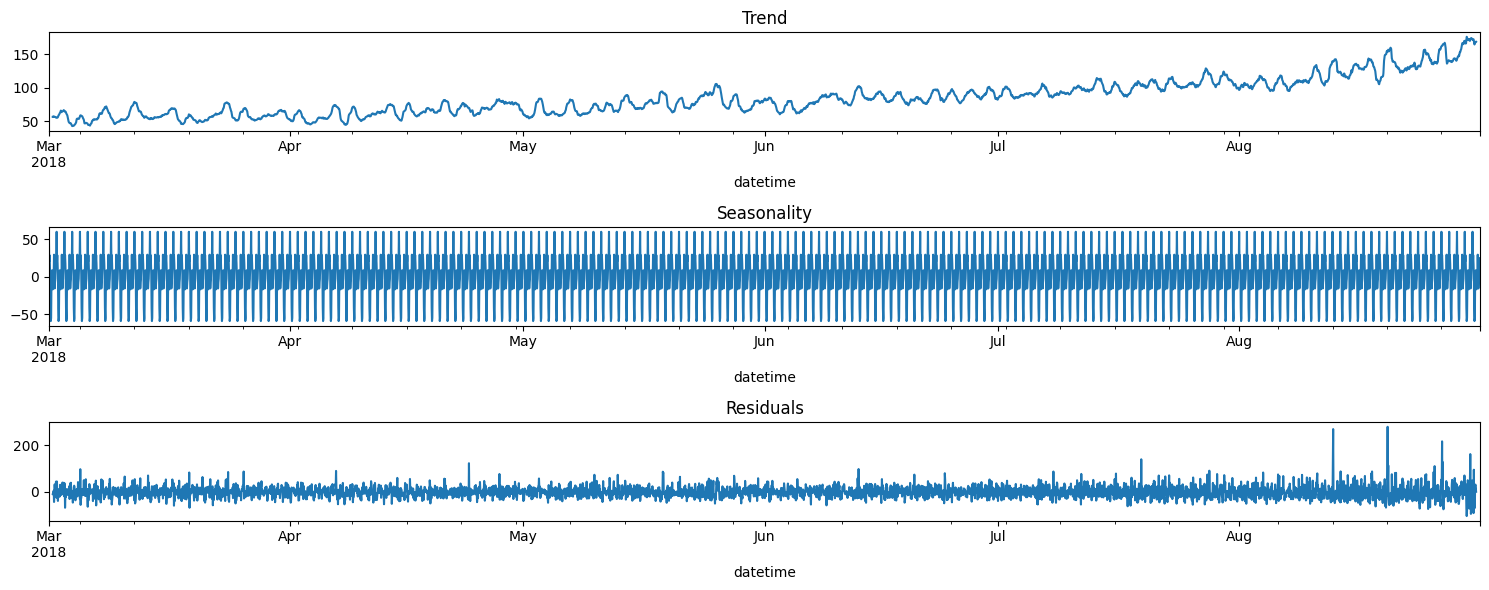

In [8]:
seasonal_chart(df)

Тренд есть. Количество заказов увеличивается.

Теперь посмотрим на промежуток в месяц.

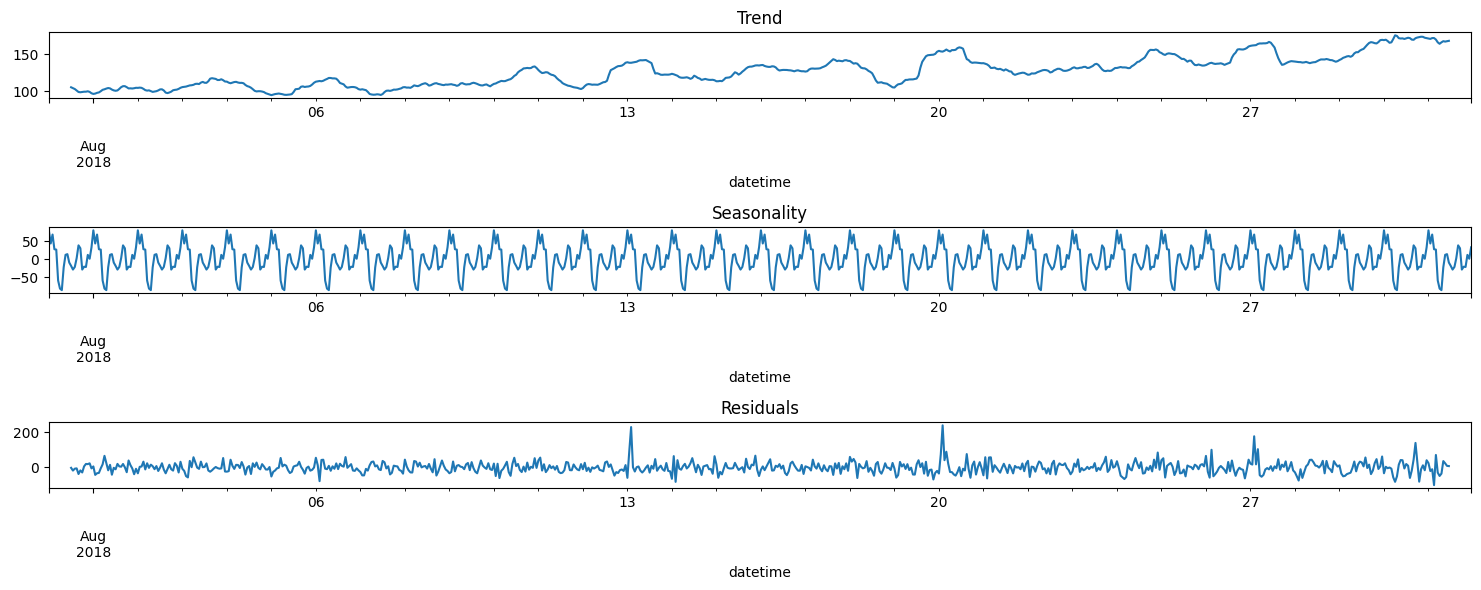

In [9]:
data_month = df['2018-07-31':]

seasonal_chart(data_month)

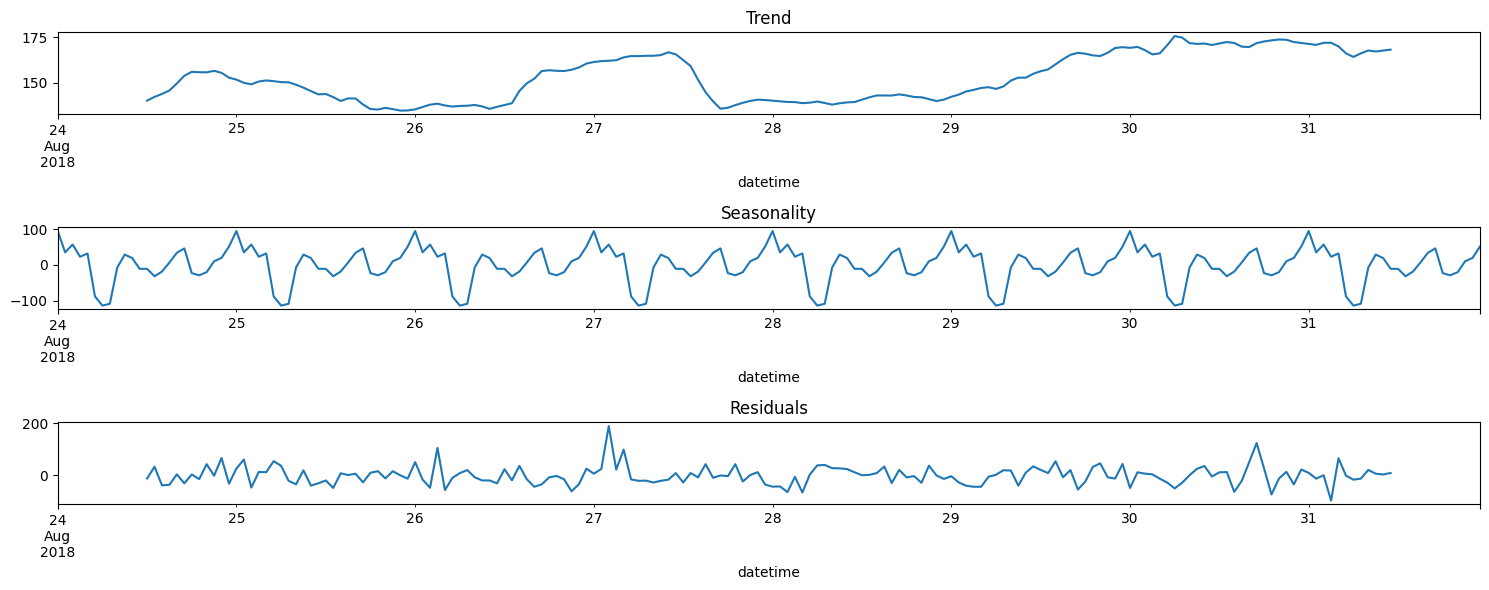

In [10]:
data_week = df['2018-08-24':]

seasonal_chart(data_week)

<Axes: xlabel='datetime'>

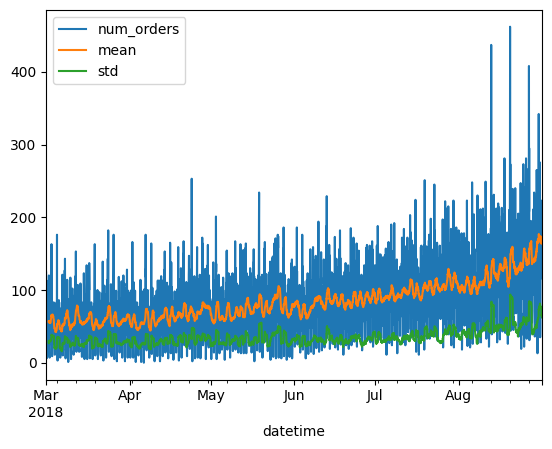

In [11]:
data_temp = df.copy()

data_temp['mean'] = data_temp['num_orders'].rolling(24).mean()
data_temp['std'] = data_temp['num_orders'].rolling(24).std()
data_temp.plot() 


Временной ряд нестационарный. Стандартное отклонение меняется.

## Обучение

Создадим новые признаки: это будет месяц, день, номер дня, час, отстающие значения и скользящее среднее.

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [13]:
data = make_features(df, 6, 24)

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=r_state)
train = train.dropna()

In [15]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Начнем с RandomForest.

In [16]:
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

params_rf = {
    "max_depth" : range(1, 15),
    "n_estimators" : range(100, 400, 10)
}
rsearch = RandomizedSearchCV(rf_model, params_rf, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
r_model = rsearch.fit(features_train, target_train)

f'Лучшие параметры {r_model.best_params_}, лучшее значение RMSE {-r_model.best_score_}'

"Лучшие параметры {'n_estimators': 390, 'max_depth': 14}, лучшее значение RMSE 25.155755030506043"

Теперь LightGBM

In [17]:
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)

params_lgbm = {
    "max_depth" : range(1, 15),
    "n_estimators" : range(100, 400, 10)
}
rsearch_lgbm = RandomizedSearchCV(lgbm_model, params_lgbm, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
r_model_lgbm = rsearch_lgbm.fit(features_train, target_train)

f'Лучшие параметры LGBM {r_model_lgbm.best_params_}, лучшее значение RMSE {-r_model_lgbm.best_score_}'

"Лучшие параметры LGBM {'n_estimators': 120, 'max_depth': 5}, лучшее значение RMSE 25.33534798603706"

И CatBoost

In [18]:
cb_model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

params_cb = {
    "iterations" : range(10, 400, 10)
}
rsearch_cb = RandomizedSearchCV(cb_model, params_cb, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=TimeSeriesSplit(n_splits=5))
r_model_cb = rsearch_cb.fit(features_train, target_train)

f'Лучшие параметры CatBoost {r_model_cb.best_params_}, лучшее значение RMSE {-r_model_cb.best_score_}'

"Лучшие параметры CatBoost {'iterations': 320}, лучшее значение RMSE 25.505829624236974"

Все модели справились хорошо, чуть лучше всех справилась RandomForest с гиперпараментрами n_estimators: 110, max_depth: 12 с показателем RMSE 25.17.

## Тестирование

Посмотрим, как поведет себя RandomForest на тестовой выборке.

In [19]:
rf_model.fit(features_train, target_train)

pred_test = rf_model.predict(features_test)

f'RMSE на тестовой выборке RandomForest: {(mean_squared_error(target_test, pred_test)) ** .5}'

'RMSE на тестовой выборке RandomForest: 44.93232659067054'

RMSE не превышает установленный порог в 48.

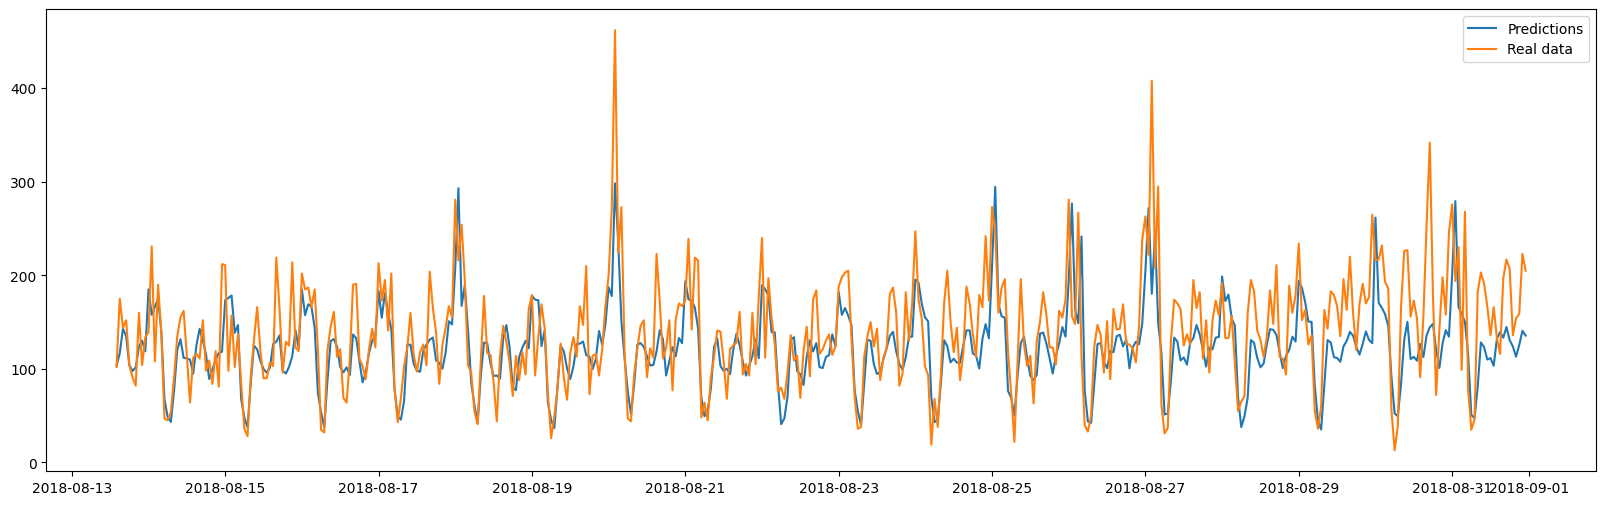

In [20]:
plt.figure(figsize=(20, 6))
plt.plot(target_test.index, pred_test, label='Predictions')
plt.plot(target_test.index, target_test, label='Real data')
plt.legend(['Predictions', 'Real data'])
plt.show()


## Итоги

Мы рассмотрели данные о заказх такси с марта 2018 по август 2018. Подобрали из трех моделей машинного обучения одну наиболее эффективную - RandomForest с показателем RMSE 44.93 на тестовой выборке.